**Maestría en Analítica de Datos e Inteligencia Artificial**

**Taller 1 de NLP**

**Modelo de clasificación de correos**

In [9]:
!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00


In [12]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313472 sha256=861eadf291156ae1910632ad04309c078550e8a96fed8b09d42a9af2ce147345
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [70]:
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
from deep_translator import GoogleTranslator
import fasttext
import fasttext.util
import spacy
from sklearn.model_selection import train_test_split

In [38]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")  # Cargar modelo de Spacy para NER


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
# 1. Carga de datos desde el archivo CSV (solo 200 correos)
file_path = '/content/emails.csv'  # Ruta de la base de datos de Enron
def load_enron_data(file_path, num_samples=200):
    df = pd.read_csv(file_path).head(num_samples)  # Cargar solo los primeros 200 correos
    print("Columnas disponibles:", df.columns)  # Mostrar las columnas disponibles
    return df

df = load_enron_data(file_path)
print("Primeras filas:")
print(df.head())


Columnas disponibles: Index(['file', 'message'], dtype='object')
Primeras filas:
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [41]:
num_rows = df.shape[0]  # Get the number of rows
num_cols = df.shape[1]  # Get the number of columns

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 200
Number of columns: 2


**Extracción del remitente**

Este código busca extraer el nombre del remitente de cada email a partir del contenido del mensaje completo (que está en la columna "message").

Pasos:

Definir una función llamada extract_sender:

Esta función recibe el texto completo del mensaje (text) como entrada.
re.search(r'From: (.+)', str(text)): Esta línea utiliza una expresión regular (re.search) para buscar una línea dentro del texto que comience con "From: ". Si la encuentra, guarda la información en la variable match.
return match.group(1).strip() if match else "Desconocido": Si se encontró una coincidencia (match no es vacío), extrae el nombre del remitente que viene después de "From: " (usando match.group(1)), le quita los espacios extra (strip()) y lo devuelve. Si no se encontró una coincidencia, devuelve "Desconocido".
Aplicar la función a la columna "message":

df['message'].apply(extract_sender): Esta línea aplica la función extract_sender a cada fila de la columna "message" del DataFrame df. El resultado de la función (el nombre del remitente) se guarda en una nueva columna llamada "sender".
Mostrar resultados:

print("Remitentes extraídos:"): Imprime un mensaje informativo.
print(df[['file', 'sender']].head()): Imprime las primeras filas del DataFrame, mostrando las columnas "file" y "sender" para que puedas ver los remitentes extraídos.

In [43]:
# 2. Extraer remitente desde el campo "message"
def extract_sender(text):
    match = re.search(r'From: (.+)', str(text))  # Buscar la línea que contiene "From:"
    return match.group(1).strip() if match else "Desconocido"  # Extraer el remitente si existe

df['sender'] = df['message'].apply(extract_sender)  # Aplicar la función a la columna "message"
print("Remitentes extraídos:")
print(df[['file', 'sender']].head())

Remitentes extraídos:
                       file                   sender
0     allen-p/_sent_mail/1.  phillip.allen@enron.com
1    allen-p/_sent_mail/10.  phillip.allen@enron.com
2   allen-p/_sent_mail/100.  phillip.allen@enron.com
3  allen-p/_sent_mail/1000.  phillip.allen@enron.com
4  allen-p/_sent_mail/1001.  phillip.allen@enron.com


**1. ¿Por qué es necesario extraer el autor de la columna?::**

Esta función recibe un texto (text) como entrada y realiza tres pasos de limpieza:
unicodedata.normalize('NFKD', str(text)): Esta línea se encarga de normalizar los caracteres Unicode. Esto significa que convierte caracteres especiales o acentuados a su forma básica. Por ejemplo, la "á" se convertiría en "a".
re.sub(r'[^\w\s]', '', text): Esta línea usa una expresión regular para eliminar los signos de puntuación del texto, dejando solo letras, números y espacios.
text.lower(): Esta línea convierte todo el texto a minúsculas.

In [44]:
# 3. Normalización Unicode y preprocesamiento del texto
def normalize_text(text):
    text = unicodedata.normalize('NFKD', str(text))  # Normalizar caracteres Unicode
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    text = text.lower()  # Convertir a minúsculas
    return text

df['message'] = df['message'].dropna().apply(normalize_text)  # Aplicar normalización
print("Texto normalizado:")
print(df['message'].head())

Texto normalizado:
0    messageid 187829811075855378110javamailevansth...
1    messageid 154649861075855378456javamailevansth...
2    messageid 242162401075855687451javamailevansth...
3    messageid 135058661075863688222javamailevansth...
4    messageid 309229491075863688243javamailevansth...
Name: message, dtype: object


In [45]:
df

,file,message,sender
0,allen-p/_sent_mail/1.,messageid 187829811075855378110javamailevansth...,phillip.allen@enron.com
1,allen-p/_sent_mail/10.,messageid 154649861075855378456javamailevansth...,phillip.allen@enron.com
2,allen-p/_sent_mail/100.,messageid 242162401075855687451javamailevansth...,phillip.allen@enron.com
3,allen-p/_sent_mail/1000.,messageid 135058661075863688222javamailevansth...,phillip.allen@enron.com
4,allen-p/_sent_mail/1001.,messageid 309229491075863688243javamailevansth...,phillip.allen@enron.com
...,...,...,...
195,allen-p/_sent_mail/270.,messageid 20686741075855691152javamailevansthy...,phillip.allen@enron.com
196,allen-p/_sent_mail/271.,messageid 58181591075855691174javamailevansthy...,phillip.allen@enron.com
197,allen-p/_sent_mail/272.,messageid 81934891075855691195javamailevansthy...,phillip.allen@enron.com
198,allen-p/_sent_mail/273.,messageid 5923131075855691216javamailevansthym...,phillip.allen@enron.com


In [35]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [46]:
# 4. Tokenización de los mensajes
def tokenize_text(text):
    return word_tokenize(text)  # Tokenizar el texto usando NLTK

df['tokens'] = df['message'].apply(tokenize_text)  # Aplicar tokenización
print("Texto tokenizado:")
print(df['tokens'].head())

Texto tokenizado:
0    [messageid, 187829811075855378110javamailevans...
1    [messageid, 154649861075855378456javamailevans...
2    [messageid, 242162401075855687451javamailevans...
3    [messageid, 135058661075863688222javamailevans...
4    [messageid, 309229491075863688243javamailevans...
Name: tokens, dtype: object


In [47]:
df

,file,message,sender,tokens
0,allen-p/_sent_mail/1.,messageid 187829811075855378110javamailevansth...,phillip.allen@enron.com,"[messageid, 187829811075855378110javamailevans..."
1,allen-p/_sent_mail/10.,messageid 154649861075855378456javamailevansth...,phillip.allen@enron.com,"[messageid, 154649861075855378456javamailevans..."
2,allen-p/_sent_mail/100.,messageid 242162401075855687451javamailevansth...,phillip.allen@enron.com,"[messageid, 242162401075855687451javamailevans..."
3,allen-p/_sent_mail/1000.,messageid 135058661075863688222javamailevansth...,phillip.allen@enron.com,"[messageid, 135058661075863688222javamailevans..."
4,allen-p/_sent_mail/1001.,messageid 309229491075863688243javamailevansth...,phillip.allen@enron.com,"[messageid, 309229491075863688243javamailevans..."
...,...,...,...,...
195,allen-p/_sent_mail/270.,messageid 20686741075855691152javamailevansthy...,phillip.allen@enron.com,"[messageid, 20686741075855691152javamailevanst..."
196,allen-p/_sent_mail/271.,messageid 58181591075855691174javamailevansthy...,phillip.allen@enron.com,"[messageid, 58181591075855691174javamailevanst..."
197,allen-p/_sent_mail/272.,messageid 81934891075855691195javamailevansthy...,phillip.allen@enron.com,"[messageid, 81934891075855691195javamailevanst..."
198,allen-p/_sent_mail/273.,messageid 5923131075855691216javamailevansthym...,phillip.allen@enron.com,"[messageid, 5923131075855691216javamailevansth..."


2. **¿Es necesario hacer la tokenización en inglés?**

Este código traduce textos al español usando Google Translator de la librería deep_translator.

Función translate_text

Recibe un texto en cualquier idioma (text).
Usa GoogleTranslator para traducir automáticamente al español (target='es').
Si el texto es corto (menos de 4500 caracteres), lo traduce directamente.
Si el texto es largo, lo divide en fragmentos de 4500 caracteres y traduce cada fragmento por separado.
Luego, une las traducciones para obtener el texto completo en español.

In [49]:
# 5. Traducción al español usando Google Translator
def translate_text(text, chunk_size=4500):  # Define chunk size for splitting
    translator = GoogleTranslator(source='auto', target='es')

    if len(text) < chunk_size:
        return translator.translate(text)
    else:
        # Split the text into chunks
        chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

        # Translate each chunk
        translated_chunks = [translator.translate(chunk) for chunk in chunks]

        # Join the translated chunks
        return ''.join(translated_chunks)

df['message_es'] = df['message'].apply(translate_text)  # Apply translation
print("Texto traducido:")
print(df['message_es'].head())

Texto traducido:
0    MessageID 187829811075855378110JavamailEvANTHY...
1    MessageID 154649861075855378456JavamailEvANTHY...
2    MessageId 242162401075855687451JavamailevANTHY...
3    MessageId 135058661075863688222JavamailEvANTHY...
4    MessageId 309229491075863688243javamailevanThy...
Name: message_es, dtype: object


In [50]:
df

,file,message,sender,tokens,message_es
0,allen-p/_sent_mail/1.,messageid 187829811075855378110javamailevansth...,phillip.allen@enron.com,"[messageid, 187829811075855378110javamailevans...",MessageID 187829811075855378110JavamailEvANTHY...
1,allen-p/_sent_mail/10.,messageid 154649861075855378456javamailevansth...,phillip.allen@enron.com,"[messageid, 154649861075855378456javamailevans...",MessageID 154649861075855378456JavamailEvANTHY...
2,allen-p/_sent_mail/100.,messageid 242162401075855687451javamailevansth...,phillip.allen@enron.com,"[messageid, 242162401075855687451javamailevans...",MessageId 242162401075855687451JavamailevANTHY...
3,allen-p/_sent_mail/1000.,messageid 135058661075863688222javamailevansth...,phillip.allen@enron.com,"[messageid, 135058661075863688222javamailevans...",MessageId 135058661075863688222JavamailEvANTHY...
4,allen-p/_sent_mail/1001.,messageid 309229491075863688243javamailevansth...,phillip.allen@enron.com,"[messageid, 309229491075863688243javamailevans...",MessageId 309229491075863688243javamailevanThy...
...,...,...,...,...,...
195,allen-p/_sent_mail/270.,messageid 20686741075855691152javamailevansthy...,phillip.allen@enron.com,"[messageid, 20686741075855691152javamailevanst...",MessageID 20686741075855691152JavamailEvANTHYM...
196,allen-p/_sent_mail/271.,messageid 58181591075855691174javamailevansthy...,phillip.allen@enron.com,"[messageid, 58181591075855691174javamailevanst...",MessageID 58181591075855691174JavamailEvANTHYM...
197,allen-p/_sent_mail/272.,messageid 81934891075855691195javamailevansthy...,phillip.allen@enron.com,"[messageid, 81934891075855691195javamailevanst...",MessageID 81934891075855691195JavamailEvANTHYM...
198,allen-p/_sent_mail/273.,messageid 5923131075855691216javamailevansthym...,phillip.allen@enron.com,"[messageid, 5923131075855691216javamailevansth...",MessageID 5923131075855691216JavamailEvANTHYME...


**3. Revisa las traducciones y averigua ¿qué otra forma de traducir el texto se puede emplear?**

In [51]:
# 5.1. Tokenización después de la traducción
df['tokens_es'] = df['message_es'].apply(tokenize_text)  # Aplicar tokenización en español

print("Texto traducido y tokenizado:")
print(df[['message_es', 'tokens_es']].head())

Texto traducido y tokenizado:
                                          message_es  \
0  MessageID 187829811075855378110JavamailEvANTHY...   
1  MessageID 154649861075855378456JavamailEvANTHY...   
2  MessageId 242162401075855687451JavamailevANTHY...   
3  MessageId 135058661075863688222JavamailEvANTHY...   
4  MessageId 309229491075863688243javamailevanThy...   

                                           tokens_es  
0  [MessageID, 187829811075855378110JavamailEvANT...  
1  [MessageID, 154649861075855378456JavamailEvANT...  
2  [MessageId, 242162401075855687451JavamailevANT...  
3  [MessageId, 135058661075863688222JavamailEvANT...  
4  [MessageId, 309229491075863688243javamailevanT...  


In [52]:
df

,file,message,sender,tokens,message_es,tokens_es
0,allen-p/_sent_mail/1.,messageid 187829811075855378110javamailevansth...,phillip.allen@enron.com,"[messageid, 187829811075855378110javamailevans...",MessageID 187829811075855378110JavamailEvANTHY...,"[MessageID, 187829811075855378110JavamailEvANT..."
1,allen-p/_sent_mail/10.,messageid 154649861075855378456javamailevansth...,phillip.allen@enron.com,"[messageid, 154649861075855378456javamailevans...",MessageID 154649861075855378456JavamailEvANTHY...,"[MessageID, 154649861075855378456JavamailEvANT..."
2,allen-p/_sent_mail/100.,messageid 242162401075855687451javamailevansth...,phillip.allen@enron.com,"[messageid, 242162401075855687451javamailevans...",MessageId 242162401075855687451JavamailevANTHY...,"[MessageId, 242162401075855687451JavamailevANT..."
3,allen-p/_sent_mail/1000.,messageid 135058661075863688222javamailevansth...,phillip.allen@enron.com,"[messageid, 135058661075863688222javamailevans...",MessageId 135058661075863688222JavamailEvANTHY...,"[MessageId, 135058661075863688222JavamailEvANT..."
4,allen-p/_sent_mail/1001.,messageid 309229491075863688243javamailevansth...,phillip.allen@enron.com,"[messageid, 309229491075863688243javamailevans...",MessageId 309229491075863688243javamailevanThy...,"[MessageId, 309229491075863688243javamailevanT..."
...,...,...,...,...,...,...
195,allen-p/_sent_mail/270.,messageid 20686741075855691152javamailevansthy...,phillip.allen@enron.com,"[messageid, 20686741075855691152javamailevanst...",MessageID 20686741075855691152JavamailEvANTHYM...,"[MessageID, 20686741075855691152JavamailEvANTH..."
196,allen-p/_sent_mail/271.,messageid 58181591075855691174javamailevansthy...,phillip.allen@enron.com,"[messageid, 58181591075855691174javamailevanst...",MessageID 58181591075855691174JavamailEvANTHYM...,"[MessageID, 58181591075855691174JavamailEvANTH..."
197,allen-p/_sent_mail/272.,messageid 81934891075855691195javamailevansthy...,phillip.allen@enron.com,"[messageid, 81934891075855691195javamailevanst...",MessageID 81934891075855691195JavamailEvANTHYM...,"[MessageID, 81934891075855691195JavamailEvANTH..."
198,allen-p/_sent_mail/273.,messageid 5923131075855691216javamailevansthym...,phillip.allen@enron.com,"[messageid, 5923131075855691216javamailevansth...",MessageID 5923131075855691216JavamailEvANTHYME...,"[MessageID, 5923131075855691216JavamailEvANTHY..."


**4. ¿Es necesario hacer la tokenización en español?**

In [54]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [55]:
import matplotlib.pyplot as plt
from collections import Counter

NER

In [57]:
# 6. Reconocimiento de Entidades Nombradas (NER) con Spacy en español
def extract_named_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]  # Extraer entidades nombradas

df['named_entities'] = df['message_es'].apply(extract_named_entities)  # Aplicar NER en español
print("Entidades nombradas extraídas:")
print(df[['file', 'named_entities']].head())

Entidades nombradas extraídas:
                       file                                     named_entities
0     allen-p/_sent_mail/1.  [(187829811075855378110JavamailEvANTHYME, CARD...
1    allen-p/_sent_mail/10.  [(154649861075855378456JavamailEvANTHYME, CARD...
2   allen-p/_sent_mail/100.  [(MessageId, GPE), (Fecha, PERSON), (18, CARDI...
3  allen-p/_sent_mail/1000.  [(MessageId, GPE), (Fecha de lunes, PERSON), (...
4  allen-p/_sent_mail/1001.  [(MessageId 309229491075863688243javamailevanT...


In [59]:
import pandas as pd

# Extracción de todas las entidades nombradas y sus etiquetas
all_entities = []
for entities in df['named_entities']:
    all_entities.extend(entities)

# Mapeo de etiquetas de spaCy a español
entity_labels_es = {
    "PERSON": "Persona",
    "NORP": "Grupo Nacionalidad o Religión",
    "FAC": "Instalaciones",
    "ORG": "Organización",
    "GPE": "Ubicación Geopolítica",
    "LOC": "Ubicación",
    "PRODUCT": "Producto",
    "EVENT": "Evento",
    "WORK_OF_ART": "Obra de Arte",
    "LAW": "Ley",
    "LANGUAGE": "Idioma",
    "DATE": "Fecha",
    "TIME": "Hora",
    "PERCENT": "Porcentaje",
    "MONEY": "Dinero",
    "QUANTITY": "Cantidad",
    "ORDINAL": "Ordinal",
    "CARDINAL": "Cardinal"
}

# Crear una lista de tuplas (palabra, etiqueta en español)
ner_data = [(entity, entity_labels_es.get(label, label)) for entity, label in all_entities]

# Crear un DataFrame de pandas
ner_df = pd.DataFrame(ner_data, columns=['Palabra Identificada', 'Tipo de Etiqueta NER'])

# Mostrar la tabla
print(ner_df)

                              Palabra Identificada Tipo de Etiqueta NER
0           187829811075855378110JavamailEvANTHYME             Cardinal
1                                   Fecha de lunes         Organización
2                                               14             Cardinal
3                                      ContentType         Organización
4                                        TextPlain             Producto
...                                            ...                  ...
7061                         Phillip K Allenhouect              Persona
7062                                      04102000             Cardinal
7063                      Phillip k Allenhouectect              Persona
7064                                    de trabajo              Persona
7065  los datos mientras estoy \nde vacaciones\n\n         Organización

[7066 rows x 2 columns]


In [60]:
ner_df

,Palabra Identificada,Tipo de Etiqueta NER
0,187829811075855378110JavamailEvANTHYME,Cardinal
1,Fecha de lunes,Organización
2,14,Cardinal
3,ContentType,Organización
4,TextPlain,Producto
...,...,...
7061,Phillip K Allenhouect,Persona
7062,04102000,Cardinal
7063,Phillip k Allenhouectect,Persona
7064,de trabajo,Persona


**5. Revisa la lista de NER y evalúa la precisión de la clasificación ¿qué técnica se puede implementar para mejorar?**

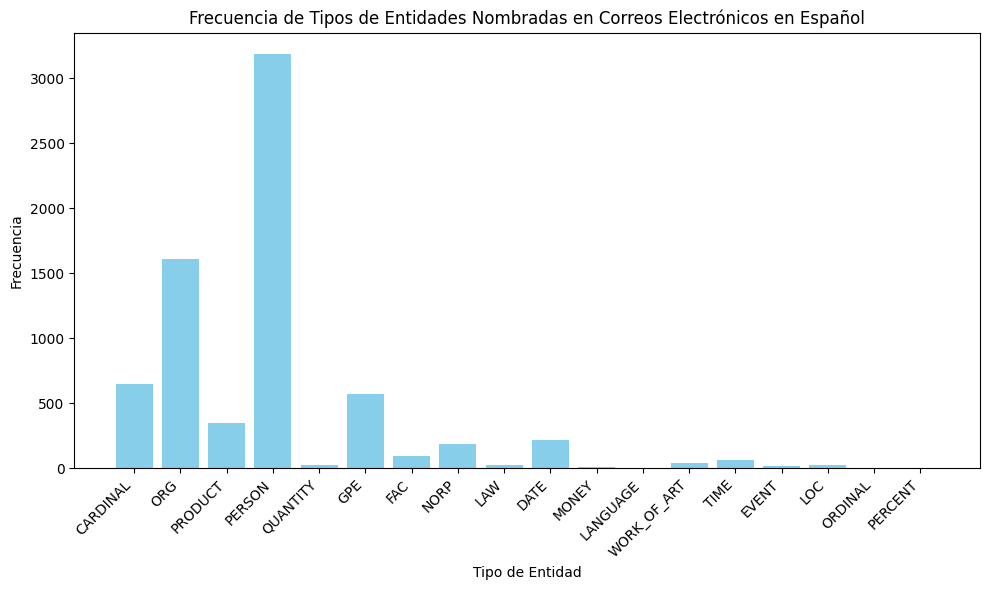

In [56]:
# Extracción de todas las entidades nombradas y sus etiquetas
all_entities = []
for entities in df['named_entities']:
    all_entities.extend(entities)

# Conteo de la frecuencia de cada tipo de entidad
entity_counts = Counter(label for entity, label in all_entities)

# Creación del gráfico de barras
entity_types = list(entity_counts.keys())
entity_frequencies = list(entity_counts.values())

plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
plt.bar(entity_types, entity_frequencies, color='skyblue')
plt.title('Frecuencia de Tipos de Entidades Nombradas en Correos Electrónicos en Español')
plt.xlabel('Tipo de Entidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

In [61]:
# 7. Vectorización con TF-IDF y One-Hot Encoding

def vectorize_texts(texts):
    tfidf = TfidfVectorizer(max_features=500)  # Configurar TF-IDF con un máximo de 500 características
    X_tfidf = tfidf.fit_transform(texts).toarray()  # Transformar el texto en vectores TF-IDF
    return X_tfidf

X_tfidf = vectorize_texts(df['message_es'])  # Aplicar vectorización
print("TF-IDF Shape:", X_tfidf.shape)  # Mostrar la forma de la matriz resultante

def one_hot_encode_labels(labels):
    encoder = OneHotEncoder()  # Inicializar el codificador One-Hot
    y_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1)).toarray()  # Codificar las etiquetas
    return y_encoded

y_encoded = one_hot_encode_labels(df['sender'])  # Aplicar One-Hot Encoding a los remitentes
print("One-Hot Encoding Shape:", y_encoded.shape)  # Mostrar la forma de la matriz resultante

TF-IDF Shape: (200, 500)
One-Hot Encoding Shape: (200, 1)


**5. ¿qué significa el resultado del TF IDF y del One Hote-Encoding?**

model = Word2Vec(...): Dentro de la función, esta línea crea un modelo Word2Vec y lo configura:

sentences: Las oraciones que se usarán para entrenar el modelo.
vector_size=100: Cada palabra se representará con un vector de 100 dimensiones.
window=5: El modelo considerará 5 palabras antes y 5 palabras después de la palabra actual para aprender las relaciones entre ellas.
min_count=2: Las palabras que aparecen menos de 2 veces en el texto se ignorarán.
workers=4: Se usarán 4 núcleos del procesador para acelerar el entrenamiento.
return model: La función devuelve el modelo Word2Vec entrenado.

word2vec_model = train_word2vec(df['tokens_es']): Esta línea llama a la función train_word2vec con las oraciones en español tokenizadas (df['tokens_es']) y guarda el modelo entrenado en la variable word2vec_model.

In [62]:
# 8. Generación de embeddings con Word2Vec
def train_word2vec(sentences):
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)  # Configurar y entrenar Word2Vec
    return model

word2vec_model = train_word2vec(df['tokens_es'])  # Aplicar entrenamiento de Word2Vec
print("Word2Vec entrenado")


Word2Vec entrenado


In [71]:
# 7. División de datos en entrenamiento, validación y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)


In [72]:
# 8. Guardar los archivos en formato FastText
def save_fasttext_file(df, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            f.write(f"__label__{row['sender']} {row['message_es']}\n")  # Guardar datos en formato FastText

save_fasttext_file(train_df, 'enron_train.txt')
save_fasttext_file(val_df, 'enron_val.txt')
save_fasttext_file(test_df, 'enron_test.txt')

**Entrenamiento del modelo**

Este código entrena un modelo de clasificación de texto con FastText utilizando el archivo 'enron_train.txt' como datos de entrenamiento. Se configura el modelo para que se entrene durante 10 épocas con una tasa de aprendizaje de 0.5 y considerando solo palabras individuales (no frases) como características. Al final del entrenamiento, se guarda el modelo en la variable fasttext_model.

In [76]:
# 9. Entrenamiento del modelo FastText con menos épocas y menor tasa de aprendizaje
def train_fasttext_classifier(train_file):
    model = fasttext.train_supervised(train_file, epoch=10, lr=0.5, wordNgrams=1)  # Reducir epoch y lr
    return model

fasttext_model = train_fasttext_classifier('enron_train.txt')  # Entrenar el modelo FastText
print("Modelo de clasificación con FastText entrenado.")


Modelo de clasificación con FastText entrenado.


**6. explique esta línea del código: model = fasttext.train_supervised(train_file, epoch=10, lr=0.5, wordNgrams=1)  # Reducir epoch y lr**

In [79]:
# 10. Evaluación del modelo en el conjunto de validación
def evaluate_fasttext_model(model, df):
    y_true = []
    y_pred = []

    for _, row in df.iterrows():
        true_label = row['sender']
        # Replace newline characters with spaces before prediction
        text_without_newline = row['message_es'].replace('\n', ' ')
        predicted_label = model.predict(text_without_newline)[0][0].replace('__label__', '')
        y_true.append(true_label)
        y_pred.append(predicted_label)

    print("Reporte de Clasificación:")
    print(classification_report(y_true, y_pred))


evaluate_fasttext_model(fasttext_model, val_df)


Reporte de Clasificación:
                         precision    recall  f1-score   support

phillip.allen@enron.com       1.00      1.00      1.00        20

               accuracy                           1.00        20
              macro avg       1.00      1.00      1.00        20
           weighted avg       1.00      1.00      1.00        20



**7. Evalúe los resultados, qué está sucediendo, qué se puede hacer para mejorar**

In [80]:
def predict_sender(text, model):
    """
    Predice el remitente de un texto dado utilizando el modelo FastText.

    Args:
        text (str): El texto para predecir el remitente.
        model (fasttext.FastText._FastText): El modelo FastText entrenado.

    Returns:
        str: El remitente predicho.
    """
    # Preprocesar el texto
    text = normalize_text(text)  # Normalizar Unicode y puntuación

    # Predecir el remitente
    prediction = model.predict(text)[0][0].replace("__label__", "")
    return prediction

# Ejemplo de uso
new_text = "Hola, quería saber si recibiste mi correo anterior sobre el proyecto."
predicted_sender = predict_sender(new_text, fasttext_model)
print(f"Remitente predicho: {predicted_sender}")

Remitente predicho: phillip.allen@enron.com


***8 ¿Qué utilidad tiene esta clase de modelos? ¿Qué aplicaciones se le ocurre? ***

**9. Abajo encuentra un código que cuenta palabras, haga un conteo de palabras para message_es y grafique las primeras 50 ¿qué puede observar del conteo?**

In [81]:
from collections import Counter

texto = "Este es un texto de ejemplo para mostrar cómo funciona Counter."
palabras = texto.split()  # Dividir el texto en palabras

frecuencia_palabras = Counter(palabras)

print(frecuencia_palabras)

Counter({'Este': 1, 'es': 1, 'un': 1, 'texto': 1, 'de': 1, 'ejemplo': 1, 'para': 1, 'mostrar': 1, 'cómo': 1, 'funciona': 1, 'Counter.': 1})


10. Su misión ahora, es revisar las fases de limpieza, preprocesamiento, NER y mejorar las fases teniendo en cuenta las diferentes opciones y bibliotecas vistas en clase

11. Bonus... ¿Te atreves a ir un paso adelante? qué tal si... entrenas el modelo de clasificación con un transformer, por ejemplo, BETO (dccuchile/bert-base-spanish-wwm-cased) en lugar de FastText... una pista # 8. Tokenización y preparación de datos para Transformer
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class EnronDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.labels = df['sender'].astype('category').cat.codes.to_list()
        self.texts = tokenizer(df['message_es'].tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.texts.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = EnronDataset(train_df, tokenizer)
val_dataset = EnronDataset(val_df, tokenizer)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(df['sender'].unique()))
